# Exercise 3

In this assignment, you will find numerical solutions to the diffusion equation. In particular, you will use an implicit method, and consider problems with both Dirichlet and Neumann boundary conditions.

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it

## Problem Overview

The 1D diffusion equation is :

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


In [1]:
# First set up the problem, with all imported libraries and global constants used in program
import numpy as np 
import scipy.linalg as linalg
import matplotlib.pyplot as plt

tc = 59      # Thermal conductivity (W m^-1 K^-1)
rho = 7900   # Density, (kg m^-3)
C = 450      # Specific heat, (J kg^-1 K^-1)
k = tc / (rho * C)   # Thermal diffusivity, (m^2 s^-1)

## Part 1 - Dirichlet Boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a Dirichlet boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$M = \pmatrix{
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+2\alpha & \\
}$$

$$b = \pmatrix{
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
}$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

First, write functions that will construct the matrix equation and boundary value term.

In [2]:
# Set up the functions used in the first part of the task
    
def matrix_equation(Nx, alpha):  
    '''
    Parameters
    ----------
    Nx: The number of elements the poker is discretised into.
    alpha: A unitless constant.

    Returns
    -------
    A square matrix, of dimensions (Nx-2,Nx-2). 
    To be used in solving a 1D diffusion problem.
    '''   
    
    r0 = np.eye(Nx-2,Nx-2, k = 0) * (1+(2*alpha))   # set the diagonal elements of the matrix
    r1 = np.eye(Nx-2,Nx-2, k = 1) * -alpha          # set the above 1 diagonal elements of the matrix
    r2 = np.eye(Nx-2,Nx-2, k = -1) * -alpha         # set the below 1 diagonal elements of the matrix

    M = r0 + r1 + r2      # Sum the elements to complete the matrix
    return M

def dirichlet_bc(Nx, alpha, d0, dN):
    '''
    Parameters
    ----------
    Nx: The number of elements the poker is discretised into.
    alpha: A unitless constant.
    d0: Temperature of the first point of the poker, in Kelvin.
    dN: Temperature of the final point of the poker, in Kelvin.
    
    Returns
    -------
    A column vector, of dimensions (Nx-2,1). 
    Sets the Dirichlet boundary conditions.
    '''
    b = np.zeros((Nx-2,1))
    b[0] = -alpha * d0        # furnace end
    b[-1] = -alpha * dN       
    return b

Now write a function which will transport the temperature distribution at time step $n$ to time step $n+1$. You will need to use an appropriate linear algebra routine.

In [3]:
# Create a function to time evolve the diffusion

def diffusion(M, b, u_n):       
    '''
    Parameters
    ----------
    M : A matrix, obtained from the `matrix_equation()` function.
    b : A column vector of the Dirichlet boundary conditions, obtained from the `dirichlet_bc()` function.
    u_n : A numpy array of the temperature at each point in the poker at time step `n`.
    
    Returns
    -------
    An array of the temperature of each point on the poker at time step `n+1`,
    calculated using SVD to solve the set of simultaneous equations. 
    '''
    _, s, v = linalg.svd(M)
    c = np.dot(_.T,u_n-b)
    w = linalg.solve(np.diag(s),c)
    u_n_plus_1 = np.dot(v.T ,w)
    return u_n_plus_1

In [4]:
# Create the two types of plotting function used in part 1 and 2.

def plot_line(x,y, legend, place, offset):
    '''
    Parameters
    ----------
    x: The x-axis data.
    y: The y-axis data.
    legend : str
        The legend labels.
    place : str
        The location of the legend.
    offset : 2-tuple, (x,y)
        The offset of the legend from 'place'.
    
    Returns
    -------
    A line plot and displays it on the screen. 
    '''
    plt.plot(x,y)
    plt.xlabel('Distance along poker (m)')
    plt.ylabel('Temperature (K)')
    plt.title('Temperature along the poker with time')     # set repeated labels for efficiency
    plt.legend(legend, loc = place, bbox_to_anchor = offset )
    plt.show()
    

def plot_imshow(x, axis):
    '''
    Parameters
    ----------
    x: The data to be plot as an image, shape (N,M).
    axis: The limits of the axis, in the form [xmin, xmax, ymin, ymax].

    Returns
    -------  
    A color plot and displays it on screen.
    '''
    plt.imshow(x, extent = axis, aspect='auto', cmap='jet')
    plt.colorbar(label = 'Temperature (K)')
    plt.xlabel('Distance along poker (m)')
    plt.ylabel('Time (s)')
    plt.title('Time evolution of the poker, with temperature')   # set repeated labels for efficeiency
    plt.show()

Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using an appropriate plotting routine.

In [5]:
# This cell time evolves the diffusion equation through the poker, for Dirichlet BC's.

# Constants that may wish to change for specific case.
L = 0.5        # Poker length (m)
Nx = 100       # Number of points poker is split into
poker = np.linspace(0,L,Nx)   # discretised poker array
del_x = poker[1]-poker[0]     # Seperatation between space points (m) 
tau =  5                      # timestep (s)
alpha = k*tau/del_x**2    

# create matricies, set boundary counditions
d0 = 1293               
dN = 273       
M = matrix_equation(Nx, alpha)
b = dirichlet_bc(Nx, alpha, d0, dN)

#initialise arrays to store data into.
u = np.zeros((Nx,1))   # temperature of the entire poker
u[0] = d0              # set the parts of poker that are BC's
u[-1] = dN
u_solve = np.full((Nx-2,1), 273)    # internal nodes

N = 10000   # number of timesteps

un_all_t = np.zeros((N, Nx))    # initialised array to store data at each timestep
convergence = []     # empty list to store convergence

# This for-loop time evolves the system by N*tau seconds each iteration
for i in range(N):
    u_solve = diffusion(M, b, u_solve)     # time evolved internal nodes
    u[1:-1] = u_solve               # set the internal nodes 
    un_all_t[i, :] = np.ravel(u)    # store data for this iteration

    # tests whether biggest difference in elements is less than atol, if so, the loop breaks.
    if np.allclose(un_all_t[i,:], un_all_t[i-1,:], atol = 0.01) == False:
        diff = sum(abs(un_all_t[i,:] - un_all_t[i-1,:]))   # calculate the total convergence
        convergence.append(diff)
        continue
    else:
        N_converge = i     # number of iterations until convergence
        print(f"The system has reached equilibrium. This took {N_converge * tau} seconds")  
        break   
    
# creates a temperature array with only elements that have changed from initialised data.     
un_all_t_filled_DBC = un_all_t[:i+1, :]    

The system has reached equilibrium. This took 7340 seconds


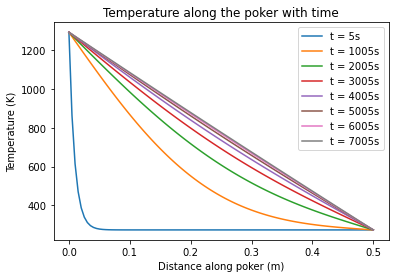

In [6]:
# This cell plots the temperatures along the poker at a variety of times.

# set up time arrays, used in legend
N_gap = 200    
t_max = N_converge * tau
time = np.arange(0, t_max, N_gap*tau) + tau  # +tau, as N=0 calculates 1 time evolution

# plots every N_gap iteration temperature array 
x = poker
y =  un_all_t_filled_DBC[::N_gap].T      
legend =  [f't = {i:.0f}s' for i in time]
place = None
offset = None

plot_line(x,y, legend, place, offset)

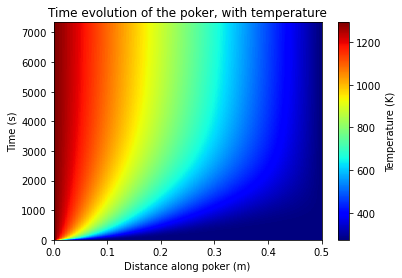

In [7]:
# Create a 2d colour plot of data
x = np.flipud(un_all_t_filled_DBC)
axis = [0, L, 0, N_converge*tau]
plot_imshow(x, axis)

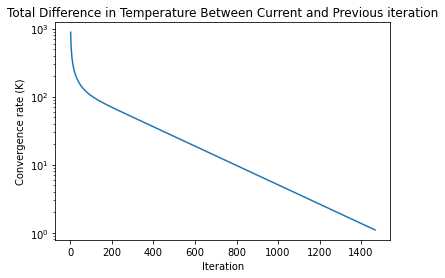

In [8]:
# This cell plots the convergence of each iteration.
# more efficient to just plot here, oppsed to using plotting function and setting 'none'.
Iteration = np.arange(0,N_converge,1)
plt.plot(Iteration[1:],convergence[1:])
plt.xlabel('Iteration')
plt.ylabel('Convergence rate (K)')
plt.title('Total Difference in Temperature Between Current and Previous iteration')
plt.yscale('log')   # use a log scale to show exponential convergence
plt.show()

### Simple Handrwitten Test Case

The cell below tests whether the temperature of the midpoint of the poker converges to the average temperature of the two end points, expected from thermodynamics. I set a tolerance of half a Kelvin, as the numerical solution is expected to have some error. The outcome of the cell below states whether the code passes or fails the test case.

In [19]:
# Test case, simple by hand, checking midpoint converges to the right temperature

if Nx % 2 == 0:
    calc_midpoint_T = un_all_t_filled_DBC[-1, int(Nx/2)-1] 
else:
    mid_T_minus = un_all_t_filled_DBC[-1,int(Nx/2)-1]
    mid_T_plus = un_all_t_filled_DBC[-1,int(Nx/2)]
    # If no midpoint, take average of 2 points eitherside
    calc_midpoint_T = (mid_T_minus + mid_T_plus) / 2

# expect
midpoint_T = (1293 + 273) / 2
atol = 0.5    # set a tolerance, as not exact

print(f'The expected temperature of the midpoint of the poker at thermal equilibrium is {midpoint_T}K')
print(f'The calculated temperature of the midpoint of the poker at thermal equilibrium is {calc_midpoint_T:.2f}K')

if calc_midpoint_T - atol <= midpoint_T <= calc_midpoint_T + atol:
    print('Therefore, the temperature of the midpoint of the poker at thermal equilibrium agrees with the physical solution.')
else:
    print('Therefore, the temperature of the midpoint of the poker at thermal equilibrium disagrees with the physical solution.')

The expected temperature of the midpoint of the poker at thermal equilibrium is 783.0K
The calculated temperature of the midpoint of the poker at thermal equilibrium is 782.83K
Therefore, the temperature of the midpoint of the poker at thermal equilibrium agrees with the physical solution.


## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the tempeterature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two noces have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$M = \pmatrix{
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
}$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

First write any new functions you need. You should be able to re-use some functions from Part 1.

In [10]:
def Neumann_matrix_equation(Nx, alpha):
    '''
    Parameters
    ----------
    Nx: The number of elements the poker is discretised into.
    alpha: A unitless constant.

    Returns
    -------
    A square matrix, of dimensions (Nx-2,Nx-2). 
    To be used in solving a 1d diffusion problem, with Neumann
    boundary conditions at one end of the poker.
    '''   
    M = matrix_equation(Nx, alpha)   # Use the same matrix as before
    M[-1,-1] = 1 + alpha             # set the change that implements Neummann BC's
    return M

# Use same dirichlet BC function, just set end with no Dirichlet BC to 0, like rest of array.
# Use same solving function `diffusion()`.

Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using a sensible plotting function.

In [11]:
# This cell time evolves the diffusion equation through the poker, for half Dirichlet, half Neumann BC's.

# Constants that may wish to change for specific case.
L = 0.5        # Poker length (m)
Nx = 100       # Number of points poker is split into
poker = np.linspace(0,L,Nx)   # discretised poker array
del_x = poker[1]-poker[0]     # Seperatation between space points (m)
tau =  5                      # timestep (s)
alpha = k*tau/del_x**2    

# create matricies, set boundary counditions
d0 = 1273   # set Dirichelt BC to temp of furnace on end with this type of BC
dN = 0      # sets Dirichlet BC to 0 on end that isn't subject to this type of BC 
M = Neumann_matrix_equation(Nx, alpha)
b = dirichlet_bc(Nx, alpha, d0, dN)

#initialise arrays to store data into.
u = np.zeros((Nx,1))   # temperature across the total poker
u[0] = d0              # set the end of the poker in the furnace, Dirichlet BC.
u_solve = np.full((Nx-2,1), 293)   # internal nodes

N = 10000    # number of timesteps

un_all_t = np.zeros((N, Nx))   # initialised array to store data at each timestep
convergence_NBC = []           # empty list to store convergence

# This for-loop time evolves the system by N*tau seconds each iteration
for i in range(N):   
    u_solve = diffusion(M, b, u_solve)  # time evolved internal nodes
    u[1:-1] = u_solve                   # set the internal nodes
    u[-1] = u[-2]                       # set by boundary conditions
    un_all_t[i, :] = np.ravel(u)        # store data for this iteration

    # tests whether biggest difference in elements is less than atol, if so, the loop breaks.
    if np.allclose(un_all_t[i,:], un_all_t[i-1,:], atol = 0.01) == False:
        diff = sum(abs(un_all_t[i,:] - un_all_t[i-1,:]))    # calculates convergence
        convergence_NBC.append(diff)
        continue     
    else:
        N_converge_NBC = i    # number of iterations until convergence
        print(f"The system has reached equilibrium. This took {N_converge_NBC * tau} seconds")  
        break
        
# create a temperature array, with only elements that have changed from initialised data.    
un_all_t_filled_NBC = un_all_t[:i+1, :]

The system has reached equilibrium. This took 23140 seconds


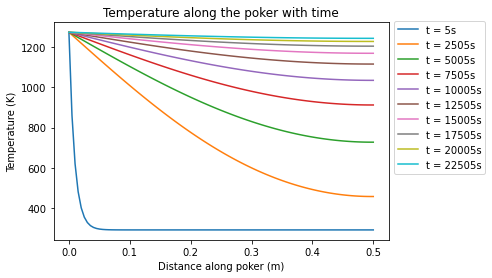

In [12]:
# This cell plots the temperatures along the poker at a variety of times.

# set up time arrays, used in legend
N_gap = 500 
t_max = N_converge_NBC * tau
time = np.arange(0, t_max, N_gap*tau) + tau  # +tau, as N=0 calculates 1 time evolution

# plots every N_gap iteration temperature array
x = poker
y =  un_all_t_filled_NBC[::N_gap].T      
legend =  [f't = {i:.0f}s' for i in time] 
place = 'lower left'
offset = (1,0.28)

plot_line(x,y, legend, place, offset)

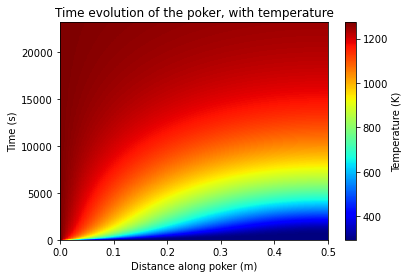

In [13]:
# Create a 2d colour plot of data
x = np.flipud(un_all_t_filled_NBC)
axis = [0, L, 0, N_converge_NBC*tau]
plot_imshow(x, axis)

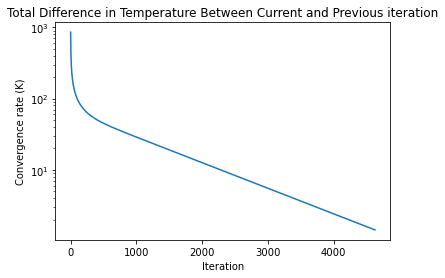

In [14]:
# more efficient to just plot here, oppsed to using plotting function and setting 'none'.
Iteration_NBC = np.arange(0,N_converge_NBC,1)
plt.plot(Iteration_NBC[1:],convergence_NBC[1:])
plt.xlabel('Iteration')
plt.ylabel('Convergence rate (K)')
plt.title('Total Difference in Temperature Between Current and Previous iteration')
plt.yscale('log')   # use a log scale to show exponential convergence
plt.show()

# Part 3

In the Markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained. You are not expected to write more than about 250-300 words.

### Answer

This code numerically solves the 1D diffusion equation, showing how the temperature of a poker evolves with time, using a backwards time finite difference method. The problem is solved initially with Dirichlet boundary conditions, and then with a combination of Neumann and Dirichlet boundary conditions.

To solve the problem, I first defined functions to use throughout the program. The `diffusion()` function solves the set of simultaneous equations resulting from the `matrix_equation()` and `dirichlet_bc()` functions, which arises from discretising the 1D diffusion equation, using a Taylor expansion, as follows:

$$u^n = Mu^{n+1} + b,$$

which can be re-arranged to be solved for the next time step as:

$$(u^n - b) M^{-1} = u^{n+1},$$

where $u$ denotes temperature, $b$ denotes boundary conditions, $M$ is the diffusion equation matrix, and $n$ denotes a time-step.

This equation can be solved using built-in `SciPy` methods. In the `diffusion()` function, I chose to use SVD to solve the set of simultaneous equations from the matrix problem, as this method has the lowest errors when considering the orders of magnitude considered in this task. 

For the second part of the problem, I define the `Neumann_matrix_equation()`, which adjusts `matrix_equation()` to be suitable for the Neumann boundary conditions.

At each iteration, I check whether the poker has reached thermal equilibrium using the NumPy `allclose` function, which tests whether all elements in two arrays are equal, within a given tolerance. This allows a comparison of every element of the poker on an individual basis, so I could see if thermal equilibrium had been reached at every point. Once thermal equilibrium has been achieved the loop stops running. This allowed me to use a for-loop, opposed to a while-loop, so I didn't have to worry about an infinite loop. At each iteration, the data is stored in a NumPy array. I chose to use this instead of a list, as I found that the run times were comparable, and for plotting it was optimal, as I didn't have to run a loop to plot multiple lines. However, to store values of convergence I used a list, as this was better suited in this case.

I set the timestep to 5 seconds and broke the poker up into 100 pieces. This makes all cells take less than a minute to run and shows a smooth temperature distribution in the colour plots. If I desired more time efficiency, I could increase the time step, and decrease the number of points on the poker, as this makes the code run faster, at the expense of a smooth distribution. 

The results from this program agree with the physically expected set of outcomes. In the case of 1D diffusion with Dirichlet boundary conditions, the line plot shows that the temperature along the poker asymptotically increases with time, until it reaches thermal equilibrium, where temperature is linearly distributed between the two end-points, as physically expected from the system. The same result is also represented more visually by the colour plot in part 1, which stacks a slice of the pokers temperature distribution at each timestep, showing how the heat diffuses through the poker over time.
In the case of 1D diffusion with a combination of Neumann and Dirichlet boundary conditions, both the line and colour plots show the heat diffusing through the poker with time, until the entire poker is the same temperature as the end being held in the furnace, agreeing with the physical expectation. 
In both cases, I also produced plots of the convergence of the system, which show the rate of change of temperature exponentially decreasing with iterations.

Overall, this numerical approximation provides accurate solutions to the 1D diffusion equation with both Dirichlet and Neumann boundary conditions.